In [ ]:
# Import the relevant libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set()
sns.set(style="whitegrid", color_codes=True)

In [ ]:
# Load the provided dataset
sales_data = pd.read_excel('monthly-sales.xlsx')

In [ ]:
sales_data.head(), sales_data.tail() # Glance at the dataset(1)

(     Month  Monthly Sales
 0  2008-01         154000
 1  2008-02          96000
 2  2008-03          73000
 3  2008-04          51000
 4  2008-05          53000,
       Month  Monthly Sales
 64  2013-05         231000
 65  2013-06         271000
 66  2013-07         329000
 67  2013-08         401000
 68  2013-09         553000)

In [ ]:
sales_data.info() ## Glance at the dataset(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Month          69 non-null     object
 1   Monthly Sales  69 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ KB


In [ ]:
sales_data = sales_data.set_index('Month')  # Set the time variable as an index
sales_data.index =  pd.date_range(start=sales_data.index[0] , periods=len(sales_data), freq='MS')
sales_data_train = sales_data.iloc[:-4, :] # Train set
sales_data_test = sales_data.iloc[-4:, :] # Test set for validation

sales_data_train.index = pd.date_range(start=sales_data_train.index[0] , periods=len(sales_data_train), freq='MS')
sales_data_test.index = pd.date_range(start=sales_data_test.index[0] , periods=len(sales_data_test), freq='MS')
sales_data_train.shape, sales_data_test.shape

((65, 1), (4, 1))

In [ ]:
sales_data_test['Monthly Sales']

2013-06-01    271000
2013-07-01    329000
2013-08-01    401000
2013-09-01    553000
Freq: MS, Name: Monthly Sales, dtype: int64

Text(0.5, 1.0, 'Time Series Plots of Sales Amount')

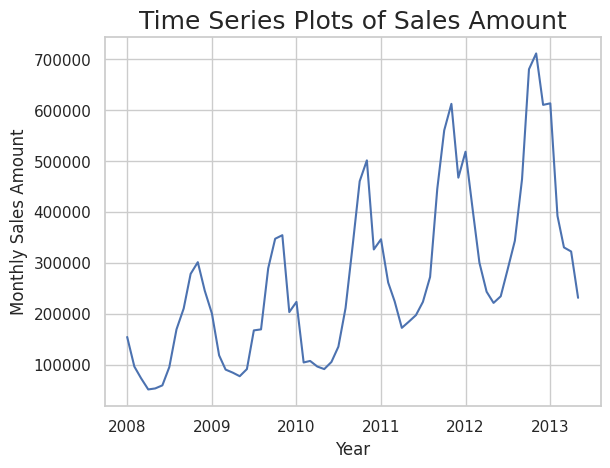

In [ ]:
fig, ax = plt.subplots()
ax.plot(sales_data_train.index, sales_data_train['Monthly Sales'])
ax.set_ylabel('Monthly Sales Amount')
ax.set_xlabel('Year')
ax.set_title('Time Series Plots of Sales Amount', size=18)

Text(0.5, 0, 'Year')

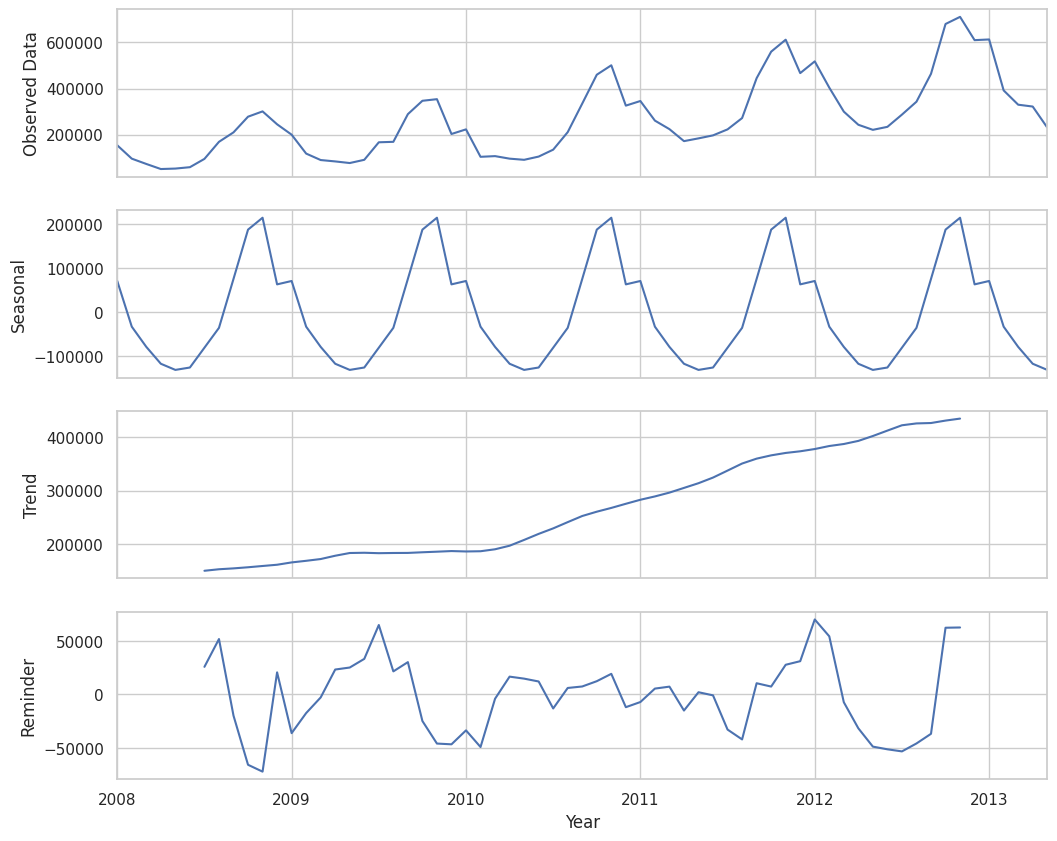

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(sales_data_train['Monthly Sales'], model='additive', period=12)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10), sharex= True)
res.observed.plot(ax=ax1)
ax1.set_ylabel('Observed Data')
res.seasonal.plot(ax=ax2)
ax2.set_ylabel('Seasonal')
res.trend.plot(ax=ax3)
ax3.set_ylabel('Trend')
res.resid.plot(ax=ax4)
ax4.set_ylabel('Reminder')

plt.xlabel("Year")

In [ ]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
sales_data_train = pd.Series(sales_data_train['Monthly Sales']).astype('float64')
ets_model = ETSModel(sales_data_train, error='mul', trend='add', seasonal = 'mul',
                     damped_trend=True, seasonal_periods=12, initial_level=sales_data_train.values.mean(), freq='MS')
ets_fitted = ets_model.fit()
print(ets_fitted.summary())

                                 ETS Results                                  
Dep. Variable:          Monthly Sales   No. Observations:                   65
Model:                      ETS(MAdM)   Log Likelihood                -758.979
Date:                Thu, 17 Apr 2025   AIC                           1555.958
Time:                        08:43:58   BIC                           1597.272
Sample:                    01-01-2008   HQIC                          1572.259
                         - 05-01-2013   Scale                            0.017
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999        nan        nan        nan         nan         nan
smoothing_trend      9.999e-05      0.047      0.002      0.998      -0.091       0.091
smoothing_season

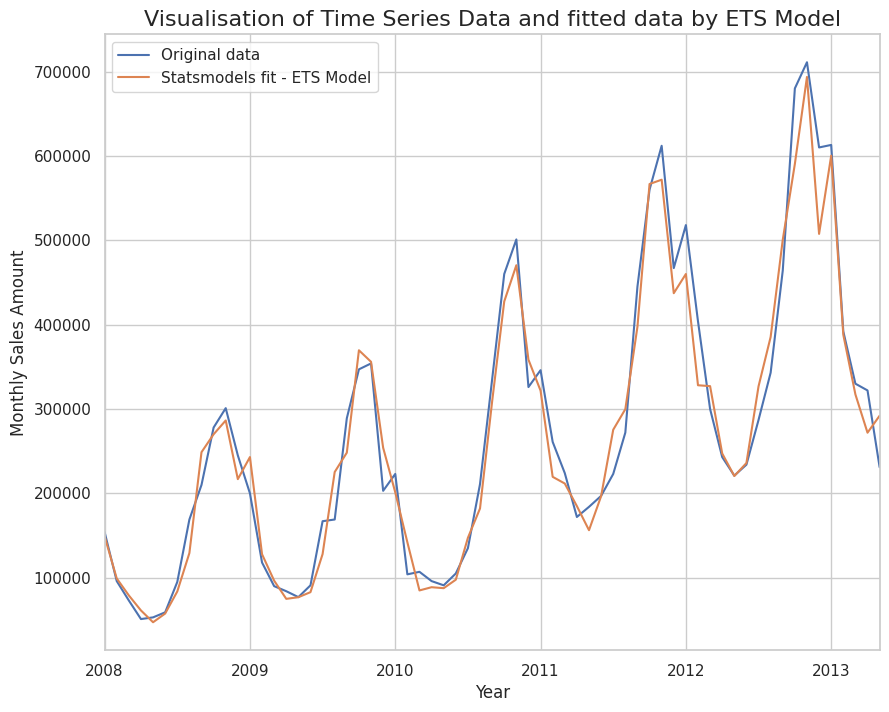

In [ ]:
plt.figure(figsize=(10,8))
sales_data_train.plot(label='Original data')
ets_fitted.fittedvalues.plot(label='Statsmodels fit - ETS Model')
plt.title('Visualisation of Time Series Data and fitted data by ETS Model' , fontsize=16)
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.legend();

In [ ]:
pred_ets= ets_fitted.fittedvalues # Store the predicted values based on ETS model as "pred_ets"

In [ ]:
expected_ets = sales_data_train.values
predicted_ets = pred_ets.values

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error

def mean_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true * 100)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def running_diff(arr, N):
    return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])

def mean_absolute_scaled_error(training_series, testing_series, prediction_series):
    errors_mean = np.abs(testing_series - prediction_series ).mean()
    d = np.abs(running_diff(training_series, 12) ).mean()
    return errors_mean/d

mse_ets  = mean_squared_error(expected_ets, predicted_ets)
rmse_ets = sqrt(mse_ets)
mae_ets  = mean_absolute_error(expected_ets, predicted_ets)
mpe_ets  = mean_percentage_error(expected_ets, predicted_ets)
mape_ets = mean_absolute_percentage_error(expected_ets, predicted_ets)
mase_ets = mean_absolute_scaled_error(expected_ets, expected_ets, predicted_ets)

print('In-Sample Error Measures of ETS Models:')
print('')
print('- RMSE: %.2f' % rmse_ets)
print('- MAE : %.2f' % mae_ets)
print('- MPE : %.2f' % mpe_ets)
print('- MAPE: %.2f' % mape_ets)
print('- MASE: %.2f' % mase_ets)

In-Sample Error Measures of ETS Models:

- RMSE: 33983.32
- MAE : 25891.55
- MPE : 0.63
- MAPE: 10.57
- MASE: 0.38


In [ ]:
# Augmented Dickey Fuller test
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(sales_data_train.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.613050
p-value: 0.997896


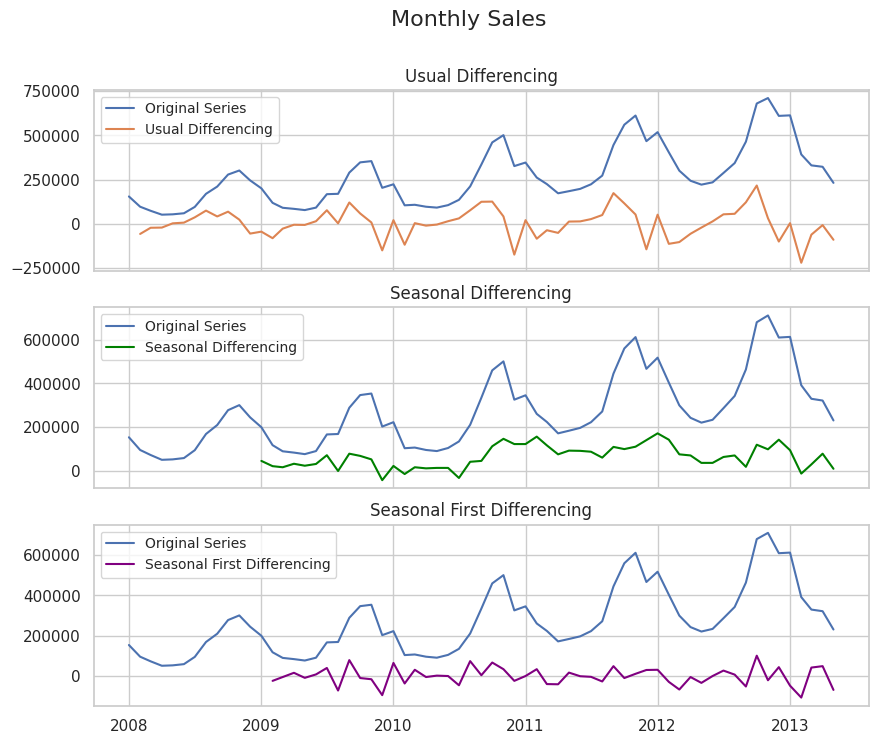

In [ ]:
# Plot
fig, axes = plt.subplots(3, 1, figsize=(10,8), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(sales_data_train, label='Original Series')
axes[0].plot(sales_data_train.diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)
sales_data_diff = sales_data_train.diff(1)

# Seasinal Dei
axes[1].plot(sales_data_train, label='Original Series')
axes[1].plot(sales_data_train.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)

# Seasinal first differencing
axes[2].plot(sales_data_train, label='Original Series')
axes[2].plot(sales_data_diff.diff(12), label='Seasonal First Differencing', color='purple')
axes[2].set_title('Seasonal First Differencing')
axes[2].legend(loc='upper left', fontsize=10)
plt.suptitle('Monthly Sales', fontsize=16)
plt.show()


In [ ]:
# Augmented Dickey Fuller test for Seasonal First Differencing Data
seasonal_first_differencing = sales_data_diff.diff(12)
result_seasonal_first_diff = adfuller(seasonal_first_differencing.dropna())
print('ADF Statistic for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[0])
print('p-value for Seasonal First Differencing: %.4f' % result_seasonal_first_diff[1])

ADF Statistic for Seasonal First Differencing: -9.4464
p-value for Seasonal First Differencing: 0.0000


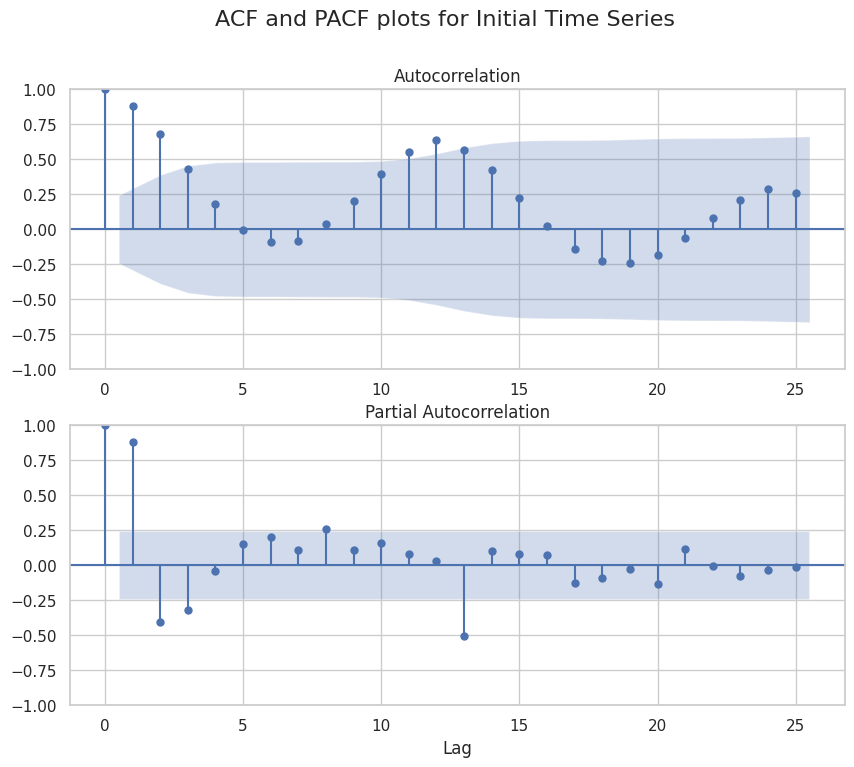

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(sales_data_train,  lags=25, ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(sales_data_train, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Initial Time Series', fontsize=16)
plt.show()

<ipython-input-13-77bd9c605284>:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.array([arr[i] - arr[i-N] for i in range(N, len(arr))])


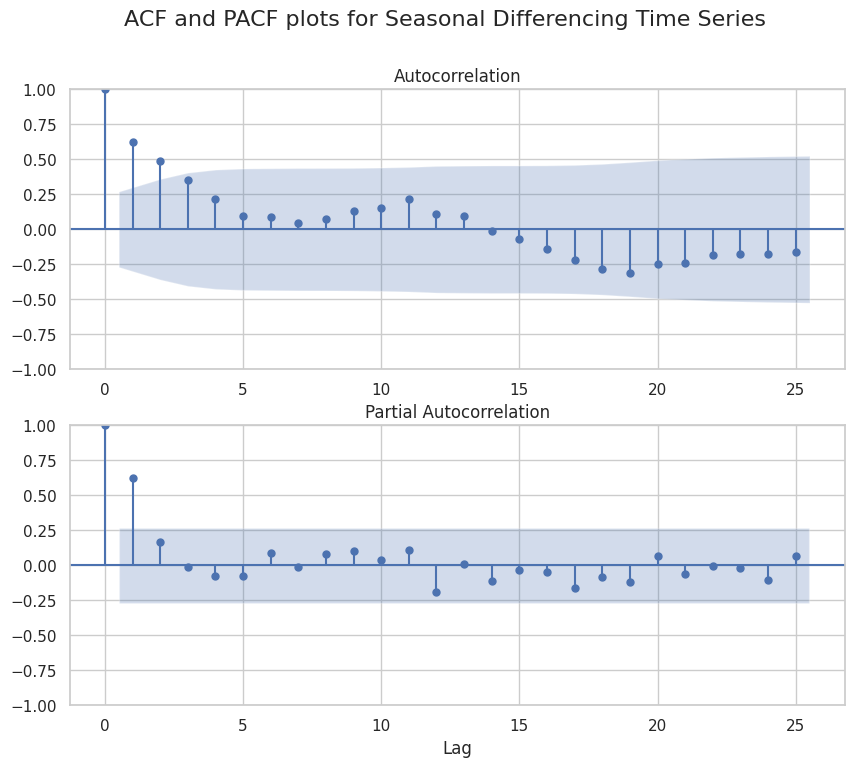

In [ ]:
seasonal_diff = running_diff(sales_data_train, 12)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff, lags=25,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal Differencing Time Series', fontsize=16)
plt.show()

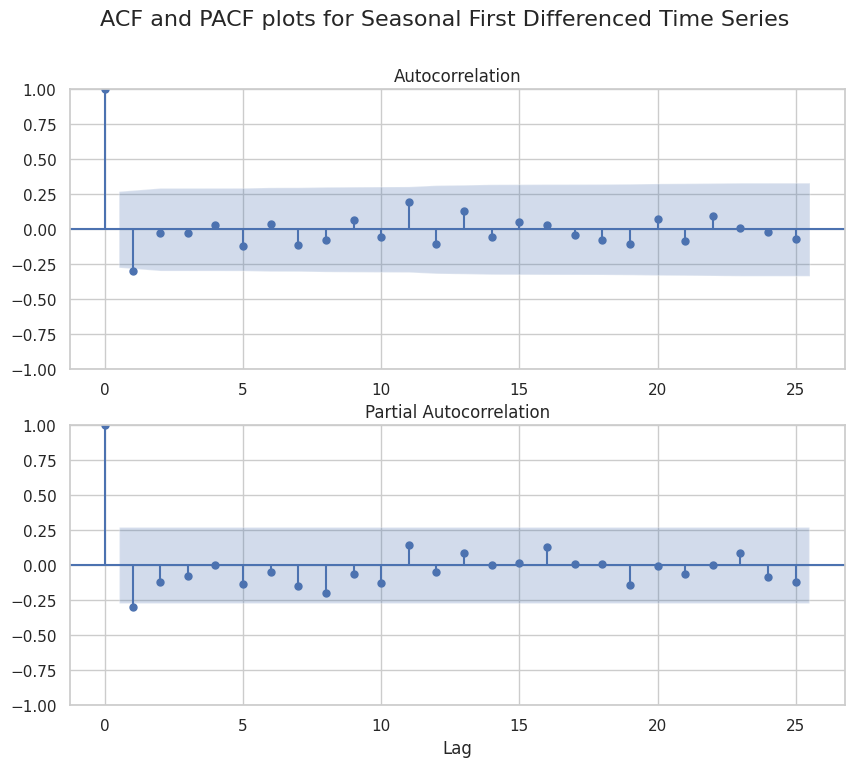

In [ ]:
seasonal_diff_1 = running_diff(seasonal_diff, 1)

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig=plot_acf(seasonal_diff_1, lags=25,  ax=ax1)

ax2 = fig.add_subplot(212)
fig=plot_pacf(seasonal_diff_1, lags=25,  ax=ax2)

plt.xlabel('Lag')
plt.suptitle('ACF and PACF plots for Seasonal First Differenced Time Series', fontsize=16)
plt.show()

In [ ]:
model_sarima = sm.tsa.statespace.SARIMAX(endog = sales_data_train,
                                         order=(0, 1, 1), seasonal_order=(0,1,0,12),
                                         trend = 't', freq = 'MS',
                                         seasonal_periods =12,
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
# FIt Model
sarima_fitted = model_sarima.fit(dynamic=False)
print(sarima_fitted.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


                                      SARIMAX Results                                      
Dep. Variable:                       Monthly Sales   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -602.879
Date:                             Thu, 17 Apr 2025   AIC                           1211.757
Time:                                     08:46:17   BIC                           1217.493
Sample:                                 01-01-2008   HQIC                          1213.942
                                      - 05-01-2013                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift        -22.1132     83.683     -0.264      0.792    -186.128     141.902
ma.L1         -0.3884      

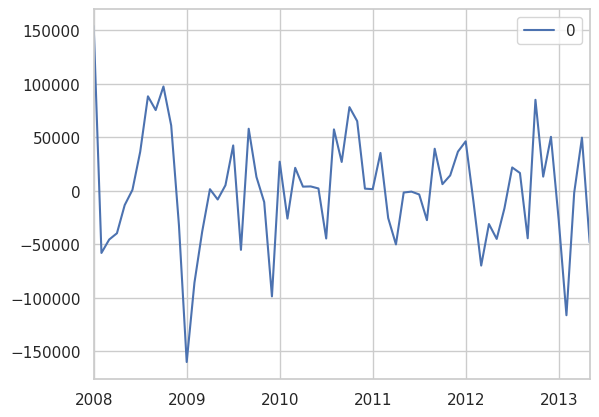

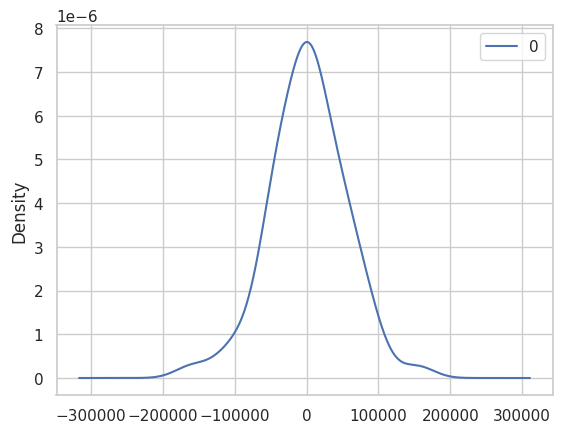

                   0
count      65.000000
mean     1666.869433
std     53192.284491
min   -159843.210757
25%    -30967.043099
50%      1602.435025
75%     36504.351403
max    154000.000000


In [ ]:
residuals = pd.DataFrame(sarima_fitted.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

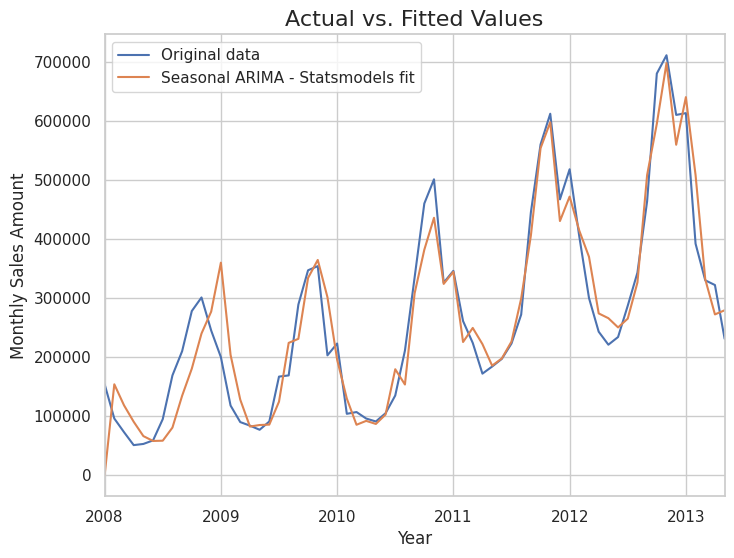

In [ ]:
# Compare the Original Time Series and Fitted values
sales_data_train.plot(label='Original data',figsize=(8,6))
sarima_fitted.fittedvalues.plot(label='Seasonal ARIMA - Statsmodels fit')
plt.ylabel("Monthly Sales Amount");
plt.xlabel("Year")
plt.title('Actual vs. Fitted Values', fontsize= 16)
plt.legend();

In [ ]:
predicted_sarima = sarima_fitted.predict().values
expected_sarima = sales_data_train.values

mse_sarima  = mean_squared_error(expected_sarima, predicted_sarima)
rmse_sarima = sqrt(mse_sarima)
mae_sarima  = mean_absolute_error(expected_sarima, predicted_sarima)
mpe_sarima  = mean_percentage_error(expected_sarima, predicted_sarima)
mape_sarima = mean_absolute_percentage_error(expected_sarima, predicted_sarima)
mase_sarima = mean_absolute_scaled_error(expected_sarima, expected_sarima, predicted_sarima)

print('In-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %f' % rmse_sarima)
print('- MAE  : %f' % mae_sarima)
print('- MPE  : %f' % mpe_sarima)
print('- MAPE : %f' % mape_sarima)
print('- MASE : %f' % mase_sarima)

In-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 52807.840876
- MAE  : 39576.055637
- MPE  : -3.478531
- MAPE : 20.196629
- MASE : 0.577355


In [ ]:
# ETS Model for Validation
sales_data = pd.Series(sales_data['Monthly Sales']).astype('float64')
ets_model_holdout = ETSModel(sales_data, error='mul', trend='add', seasonal = 'mul',
                             damped_trend=True, seasonal_periods=12,
                             initial_level=sales_data_train.values.mean(), freq='MS')
ets_fitted_holdout = ets_model_holdout.fit()
# Predicted values for holdout samples (test samples) - ETS model
ets_fitted_holdout.predict()[-4:]

2013-06-01    250578.887653
2013-07-01    371517.331563
2013-08-01    435702.681132
2013-09-01    580149.557333
Freq: MS, dtype: float64

In [ ]:
# Seasonal ARIMA Model for Validation
model_sarima_holdout = sm.tsa.statespace.SARIMAX(endog = sales_data,
                                                 order=(0, 1, 1), seasonal_order=(0,1,0,12),
                                                 trend = 't', freq = 'MS',
                                                 seasonal_periods =12,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
sarima_fitted_holdout = model_sarima_holdout.fit(dynamic=False)
# Predicted values for holdout samples (test samples) - Seasonal ARIMA model
sarima_fitted_holdout.predict()[-4:]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


2013-06-01    265077.673473
2013-07-01    322917.680752
2013-08-01    383874.673687
2013-09-01    516710.170399
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
holdout_results = pd.DataFrame({'actual': sales_data_test['Monthly Sales'],
                                 'predicted_ETS': ets_fitted_holdout.predict()[-4:].values,
                                 'predicted_ARIMA': sarima_fitted_holdout.predict()[-4:].values },
                               index = sales_data_test.index)
holdout_results

actual  predicted_ETS  predicted_ARIMA
2013-06-01  271000  250578.887653    265077.673473
2013-07-01  329000  371517.331563    322917.680752
2013-08-01  401000  435702.681132    383874.673687
2013-09-01  553000  580149.557333    516710.170399

In [ ]:
sales_data_train

2008-01-01    154000.0
2008-02-01     96000.0
2008-03-01     73000.0
2008-04-01     51000.0
2008-05-01     53000.0
                ...   
2013-01-01    613000.0
2013-02-01    392000.0
2013-03-01    330000.0
2013-04-01    322000.0
2013-05-01    231000.0
Freq: MS, Name: Monthly Sales, Length: 65, dtype: float64

In [ ]:
# Holdout-Sample Errors Comparison
# ETS Model
mse_ets_hos  = mean_squared_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
rmse_ets_hos = sqrt(mse_ets_hos)
mae_ets_hos  = mean_absolute_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mpe_ets_hos  = mean_percentage_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mape_ets_hos = mean_absolute_percentage_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])
mase_ets_hos = mean_absolute_scaled_error(sales_data_train.values, sales_data_test['Monthly Sales'], holdout_results['predicted_ETS'])

print('Holdout-Sample Error Measures of ETS Models:')
print(' ')
print('- RMSE : %.3f' % rmse_ets_hos)
print('- MAE  : %.3f' % mae_ets_hos)
print('- MPE  : %.3f' % mpe_ets_hos)
print('- MAPE : %.3f' % mape_ets_hos)
print('- MASE : %.3f' % mase_ets_hos)
print(' ')
# (Seasonal) ARIMA Model
mse_sarima_hos  = mean_squared_error(sales_data_test['Monthly Sales'], holdout_results['predicted_ARIMA'])
rmse_sarima_hos = sqrt(mse_sarima_hos)
mae_sarima_hos  = mean_absolute_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mpe_sarima_hos  = mean_percentage_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mape_sarima_hos = mean_absolute_percentage_error(sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
mase_sarima_hos = mean_absolute_scaled_error(sales_data_train.values, sales_data_test['Monthly Sales'],  holdout_results['predicted_ARIMA'])
print(' ')
print('Holdout-Sample Error Measures of Seasonal ARIMA Models:')
print(' ')
print('- RMSE : %.3f' % rmse_sarima_hos)
print('- MAE  : %.3f' % mae_sarima_hos)
print('- MPE  : %.3f' % mpe_sarima_hos)
print('- MAPE : %.3f' % mape_sarima_hos)
print('- MASE : %.3f' % mase_sarima_hos)

Holdout-Sample Error Measures of ETS Models:
 
- RMSE : 32272.743
- MAE  : 31197.671
- MPE  : -4.738
- MAPE : 8.506
- MASE : 0.455
 
 
Holdout-Sample Error Measures of Seasonal ARIMA Models:
 
- RMSE : 20507.908
- MAE  : 16354.950
- MPE  : 3.717
- MAPE : 3.717
- MASE : 0.239


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dynamic. After release 0.14, this will raise.
  warnings.warn(


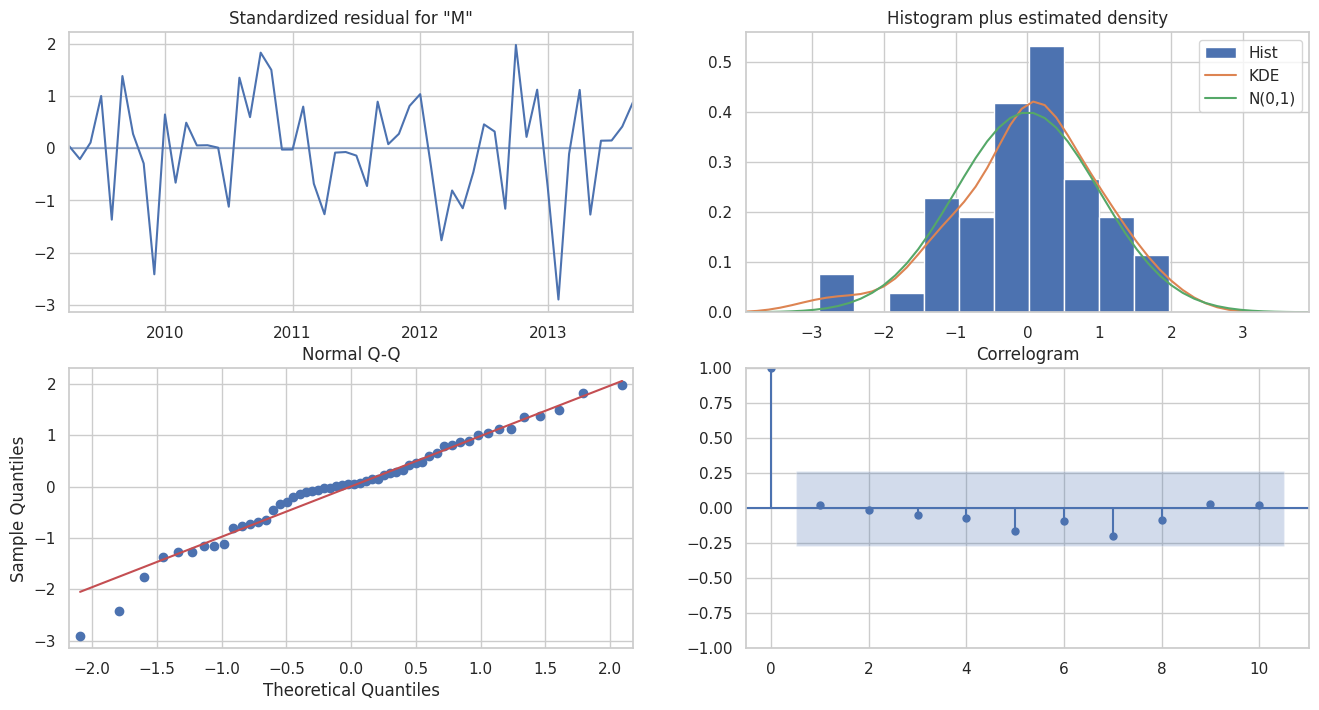

In [ ]:
# Seasonal ARIMA Model for Forecasting
model_sarima_final = sm.tsa.statespace.SARIMAX(sales_data, order=(0, 1, 1),
                                             seasonal_order=(0,1,0,12), trend = 't',
                                             seasonal_periods =12,
                                             enforce_stationarity=False, enforce_invertibility=False)
# FIt Model
sarima_fitted_final = model_sarima_final.fit(dynamic=False)
sarima_fitted_final.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
# Forecast the nest 4 periods of Sales Amount
fcast = sarima_fitted_final.get_forecast(4)
forecast_results = pd.DataFrame({'forecast_mean': fcast.predicted_mean,
                                 'forecast_high_95': fcast.conf_int(alpha= 0.05).iloc[:,1],
                                 'forecast_high_80': fcast.conf_int(alpha= 0.20).iloc[:,1],
                                 'forecast_low_80': fcast.conf_int(alpha= 0.20).iloc[:,0],
                                 'forecast_low_95': fcast.conf_int(alpha= 0.05).iloc[:,0],
                                })
forecast_results.index = pd.date_range(start=forecast_results.index[0] , periods=len(forecast_results), freq='MS')
forecast_results

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_periods']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


forecast_mean  forecast_high_95  forecast_high_80  \
2013-10-01  756469.982843     837662.052684     809558.623775   
2013-11-01  788700.836873     884287.127317     851201.352765   
2013-12-01  688949.274531     797029.456049     759619.106692   
2014-01-01  693215.295819     812487.724959     771203.345342   

            forecast_low_80  forecast_low_95  
2013-10-01    703381.341911    675277.913002  
2013-11-01    726200.320980    693114.546428  
2013-12-01    618279.442370    580869.093013  
2014-01-01    615227.246295    573942.866679

Text(0.5, 1.0, 'Actual and Forecast Values')

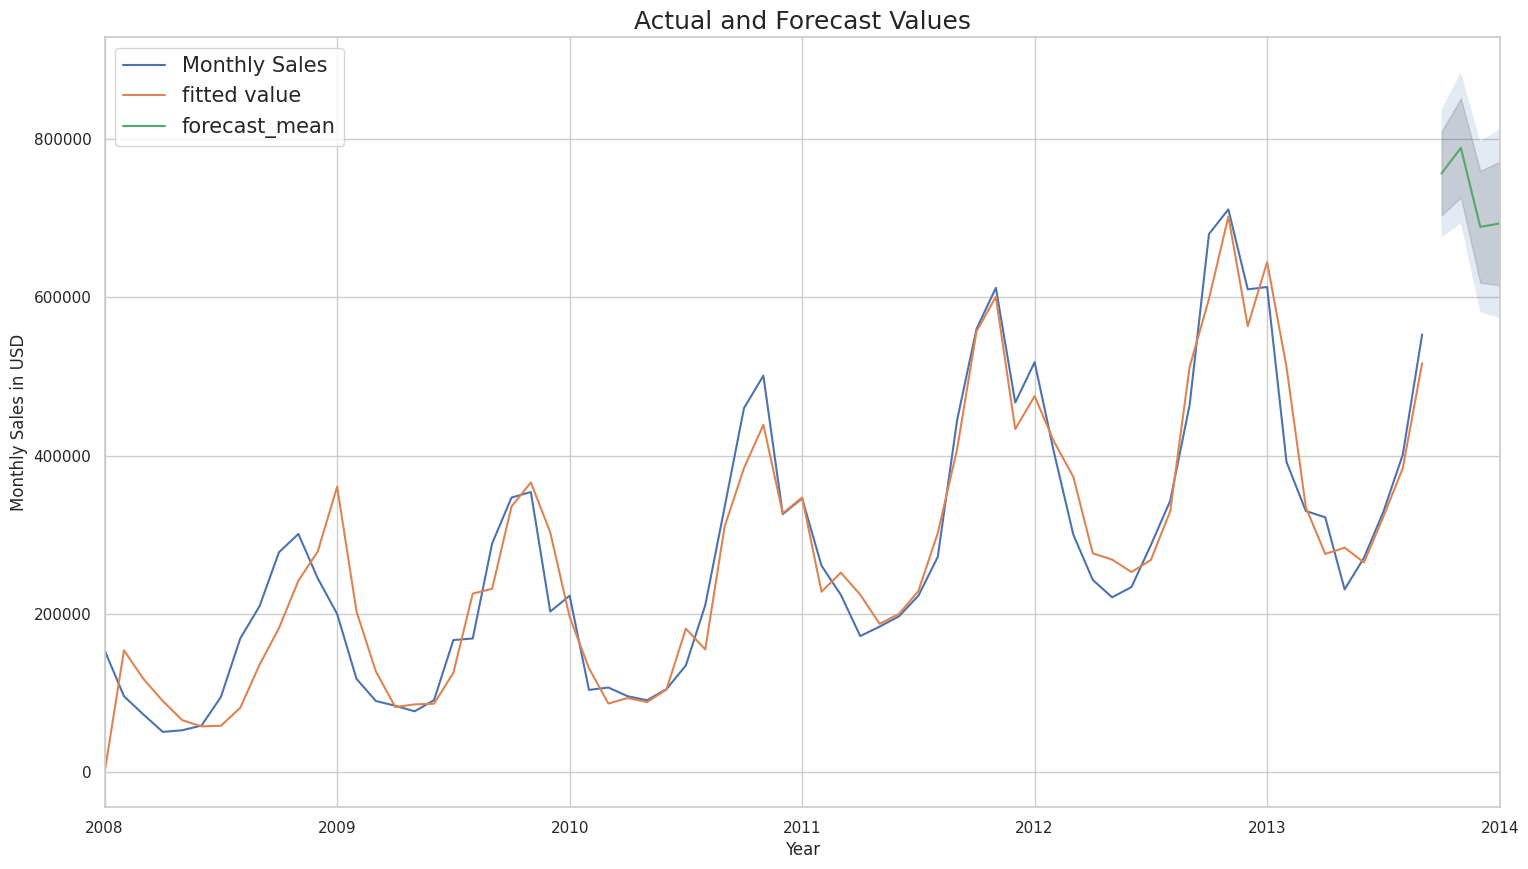

In [ ]:
# Visualize the forecast results
sales_data.plot(figsize=(18,10))
sarima_fitted_final.fittedvalues.plot(label = 'fitted value')
forecast_results.forecast_mean.plot()
upper_series_80 = forecast_results.forecast_high_80
lower_series_80 = forecast_results.forecast_low_80
upper_series_95 = forecast_results.forecast_high_95
lower_series_95 = forecast_results.forecast_low_95

plt.fill_between(upper_series_80.index,
                 lower_series_80,
                 upper_series_80,
                 color='k', alpha=.15)

plt.fill_between(lower_series_95.index,
                 lower_series_95,
                 upper_series_95,
                 color= None, linestyle ='--', alpha=.15)
plt.legend(loc = 'upper left', fontsize =15)
plt.xlabel('Year')
plt.ylabel('Monthly Sales in USD')
plt.title('Actual and Forecast Values', fontsize = 18)